In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

import trueskill
from scipy.stats import norm
from sqlalchemy import select, insert, update, create_engine, Date, and_
from sqlalchemy.orm import Session, aliased
import data
from match_report import read_player_skill_for_team, plot_match_qualities, plot_skill_distributions

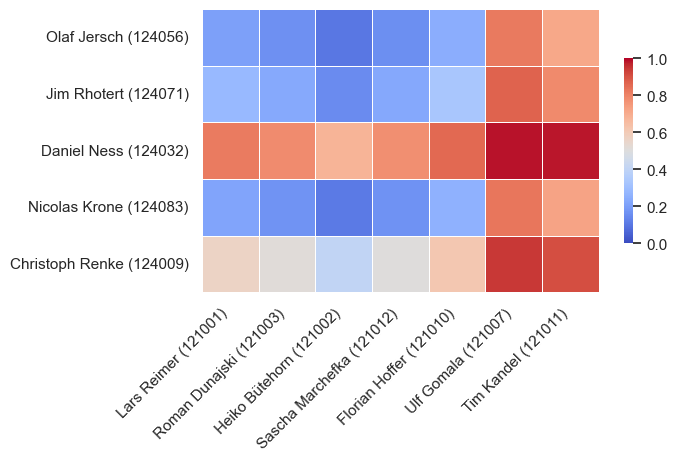

In [6]:
# TODO Better layout for this notebook
# Functions in notebook for:
#   - Previous lineup
#   - Position distribution per player
#   - Some kind of distribution plot to see std
#   - Get best possible lineup (with best 4 of them?) 
#   - 

ignore_players = ["Frank Fuhlrott", "Timo Trauslen", "Andreas Schmidt", "Sven Rohde"]
han96 = read_player_skill_for_team("Hannover 96", "DBH Bezirksliga 2", ignore_players)
opp = read_player_skill_for_team("PDC Hannover e.V.", "DBH Bezirksliga 2")
f = plot_match_qualities(han96, opp)

[6.47718911e-07 6.87121344e-07 7.28813775e-07 7.72922546e-07
 8.19580562e-07 8.68927603e-07 9.21110660e-07 9.76284273e-07
 1.03461090e-06 1.09626128e-06 1.16141484e-06 1.23026009e-06
 1.30299508e-06 1.37982777e-06 1.46097660e-06 1.54667088e-06
 1.63715133e-06 1.73267064e-06 1.83349392e-06 1.93989938e-06
 2.05217884e-06 2.17063837e-06 2.29559895e-06 2.42739710e-06
 2.56638560e-06 2.71293421e-06 2.86743040e-06 3.03028013e-06
 3.20190868e-06 3.38276147e-06 3.57330494e-06 3.77402745e-06
 3.98544022e-06 4.20807833e-06 4.44250168e-06 4.68929611e-06
 4.94907442e-06 5.22247754e-06 5.51017572e-06 5.81286968e-06
 6.13129193e-06 6.46620805e-06 6.81841802e-06 7.18875765e-06
 7.57810001e-06 7.98735694e-06 8.41748059e-06 8.86946501e-06
 9.34434784e-06 9.84321199e-06 1.03671874e-05 1.09174531e-05
 1.14952385e-05 1.21018262e-05 1.27385532e-05 1.34068135e-05
 1.41080602e-05 1.48438073e-05 1.56156327e-05 1.64251797e-05
 1.72741604e-05 1.81643572e-05 1.90976263e-05 2.00758998e-05
 2.11011885e-05 2.217558

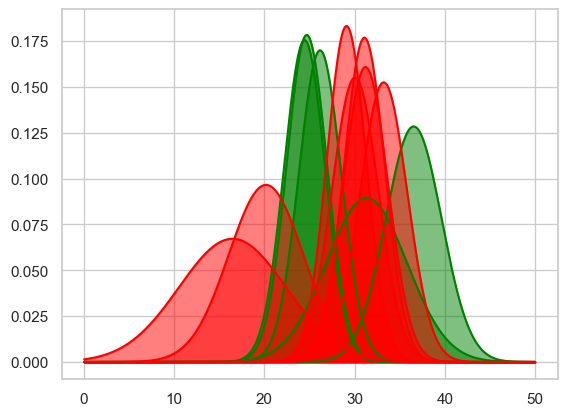

In [45]:

for player in han96:
    x = np.linspace(0, 50, 1000)
    y = norm.pdf(x, player[2].mu, player[2].sigma)
    plt.plot(x, y, color="green", label=player[0])
    plt.fill_between(x, y, color="green", alpha=0.5)
for player in opp:
    x = np.linspace(0, 50, 1000)
    y = norm.pdf(x, player[2].mu, player[2].sigma)
    plt.plot(x, y, color="red", label=player[0])
    plt.fill_between(x, y, color="red", alpha=0.5)


['name: 5000', 'team: 5000', 'x: 5000', 'y: 5000']


,name,team,x,y
1301,Jim Rhotert,124,15.065065,2.420208e-06
2834,Daniel Ness,124,41.741742,3.164942e-02
1117,Jim Rhotert,124,5.855856,9.874139e-18
3369,Nicolas Krone,124,18.468468,3.757891e-03
2210,Daniel Ness,124,10.510511,7.266075e-17


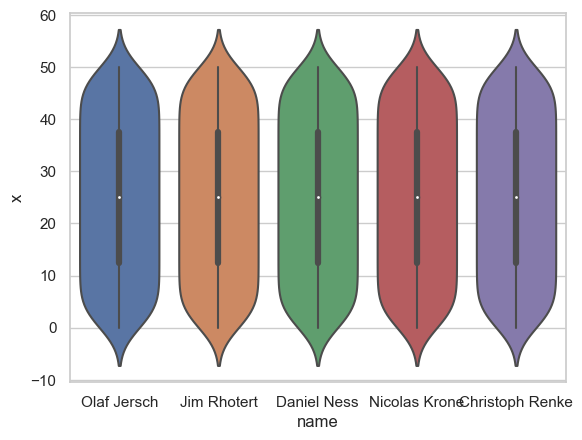

In [49]:

# Create the data
x = np.linspace(0, 50, 1000)
y = np.concatenate([norm.pdf(x, player[2].mu, player[2].sigma) for player in han96])
data_dict = {
        "name" : np.repeat([p[0] for i, p in enumerate(han96)], 1000),
        "team" : np.repeat([str(p[1])[:3] for p in han96], 1000),
        "x" : np.tile(x, len(han96)),
        "y" : y
    }

print([f"{k}: {len(v)}" for k,v in data_dict.items()])
df = pd.DataFrame(data_dict)


sns.violinplot(df, x="name", y="x",)

df.sample(5)
